### Load Libraries

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.svm import SVC

from sklearn import set_config
set_config(display='diagram')

plt.style.use('bmh')

### Load Data

In [83]:
data = pd.read_csv("../data/train.csv",index_col=0)
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [84]:
# check missing values
data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### Exploratory Data Analysis

number of survived and non_survived passengers

In [85]:
y = data['Survived']
survived = sum(y == 1)
not_survived = sum(y == 0)

print("survived : %s \nnon_survived: %s" 
     %(survived,not_survived))

survived : 342 
non_survived: 549


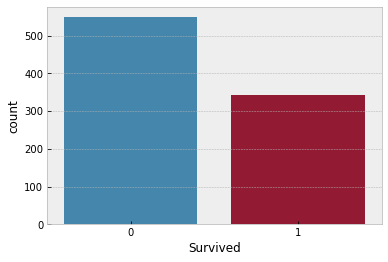

In [86]:
sns.countplot(x='Survived',data=data);

proportion of surviving 1st class passengers with regards to the total number of 1st class passengers

In [87]:
data_first_class = data [data['Pclass'] == 1] 
data_first_class_survived = data[(data['Pclass'] == 1) & (data['Survived'] == 1)]

prop = data_first_class_survived.shape[0] / data_first_class.shape[0] * 100
print(f'{round(prop,2)} percent of 1st class passengers were survived.') 

62.96 percent of 1st class passengers were survived.


Bar chart for Sex

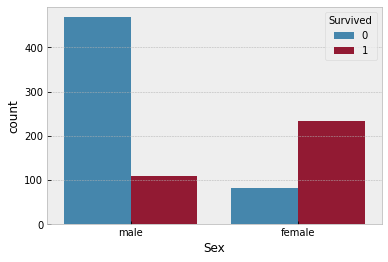

In [88]:
sns.countplot(data = data, x = 'Sex', hue = "Survived");

Bar chart for  Pclass

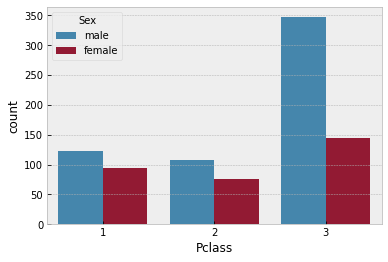

In [89]:
sns.countplot(x='Pclass',data=data,hue='Sex');

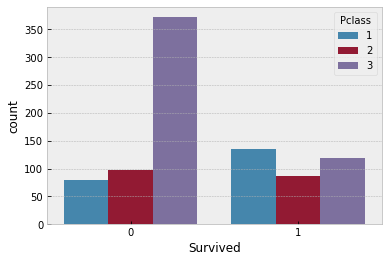

In [90]:
sns.countplot(x="Survived", data = data, hue = "Pclass");

Age distribution

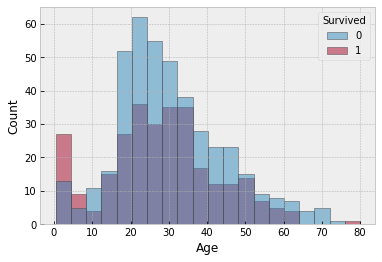

In [91]:
sns.histplot(
    data = data,
    x = "Age", hue="Survived",
    multiple='layer',
    edgecolor=".3",
    linewidth=.5,
);

In [92]:
mean_age_s = data[data['Survived'] == 1].Age.mean()
mean_age_n = data[data['Survived'] == 0].Age.mean()

print(f'average age of survived passengers is: {round(mean_age_s,2)}\naverage age of non_survived passengers is : {round(mean_age_n,2)}.')


average age of survived passengers is: 28.34
average age of non_survived passengers is : 30.63.


Fare distribution

<AxesSubplot:xlabel='Fare', ylabel='Survived'>

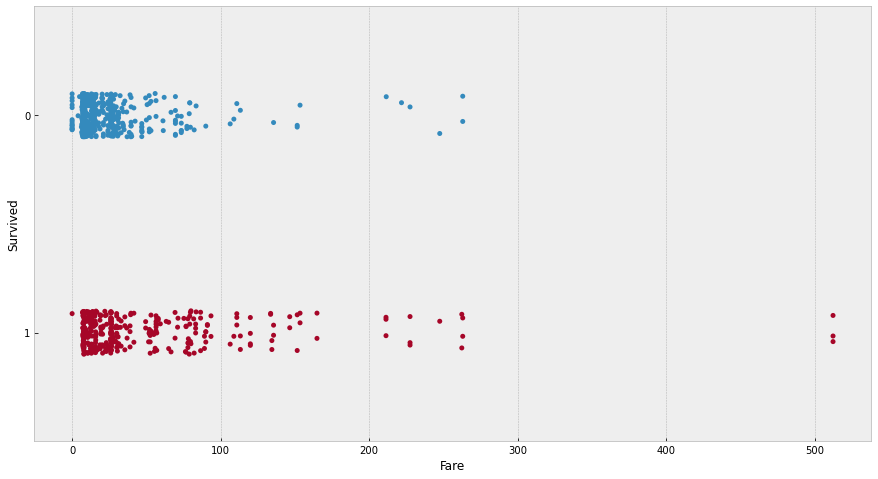

In [93]:
plt.figure(figsize=(15,8))
sns.stripplot(x=data["Fare"], y=data["Survived"].astype(str), size = 5)

Bar chart for Embarked

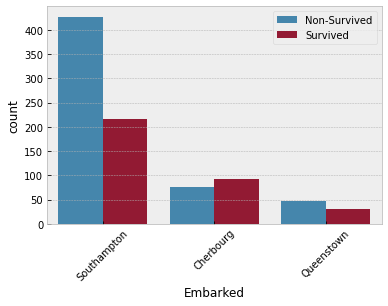

In [94]:
ax = sns.countplot(x='Embarked',data=data,hue='Survived');
ax.set_xticklabels(['Southampton','Cherbourg','Queenstown']);
plt.xticks(rotation = 45);
plt.legend(['Non-Survived', 'Survived']);

Bar chart for Relatives (SibSp + Parch)

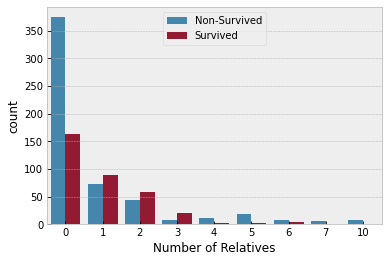

In [95]:
data['Relatives'] = data['SibSp'] + data['Parch'] 
ax = sns.countplot(x='Relatives',data=data,hue='Survived');
ax.set_xlabel("Number of Relatives")
plt.legend(['Non-Survived', 'Survived']);

Define small and large families

In [96]:
cut_bins = [-0.1,3,10]
cut_labels= ['small','big']
data['Family']= pd.cut(data['Relatives'], bins=cut_bins,labels=cut_labels,ordered = False)
data.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,Family
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,small
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,small
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,small


Bar chart for family size

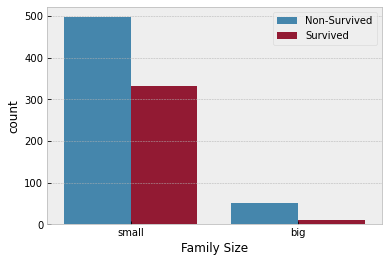

In [97]:
ax = sns.countplot(x='Family',data=data,hue='Survived');
ax.set_xlabel("Family Size")
plt.legend(['Non-Survived', 'Survived']);

In [98]:
data.groupby(["Survived","Family"]).count()[['Pclass']]

Pclass
Survived Family        
0        small      497
         big         52
1        small      332
         big         10

### Logistic Regression

In [99]:
# define features and target
X = data.drop(['Survived','SibSp','Parch','Family'], axis=1)
y = data['Survived']

In [100]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Pclass     891 non-null    int64  
 1   Name       891 non-null    object 
 2   Sex        891 non-null    object 
 3   Age        714 non-null    float64
 4   Ticket     891 non-null    object 
 5   Fare       891 non-null    float64
 6   Cabin      204 non-null    object 
 7   Embarked   889 non-null    object 
 8   Relatives  891 non-null    int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 69.6+ KB


In [101]:
# Train-test split of the data
X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=100)

#### Feature Engineering

In [102]:
# data summary
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Survived   891 non-null    int64   
 1   Pclass     891 non-null    int64   
 2   Name       891 non-null    object  
 3   Sex        891 non-null    object  
 4   Age        714 non-null    float64 
 5   SibSp      891 non-null    int64   
 6   Parch      891 non-null    int64   
 7   Ticket     891 non-null    object  
 8   Fare       891 non-null    float64 
 9   Cabin      204 non-null    object  
 10  Embarked   889 non-null    object  
 11  Relatives  891 non-null    int64   
 12  Family     891 non-null    category
dtypes: category(1), float64(2), int64(5), object(5)
memory usage: 91.5+ KB


**Columns and summarizing thoughts for logisitc regression:**

`Pclass`: Since it is ordinal and already numeric, keep it as it is 

`Name:` Length of name might be a useful feature

`Sex:` Categorical, but not ordinal, needs onehot encoding

`Àge:` Numerical data, impute (e.g. mean of class), needs binning 

`SibSp:` Numerical data, It is not considered in the features. Insetead of it, Relatives is considered 

`Parch:` Numerical data, It is not considered in the features. Insetead of it, Relatives is considered 

`Relatives:` Numerical data, It is sum of SibSb and Parch, needs binning 

`Ticket:` It is not considered in the Features

`Fare:` Scaling definitely needed, outliers to be considered (see box plot)

`Cabin:` Extract first letter and length of number, 

`Èmbarked:` Imputing (most frequent), needs onehot encoding

##### Define Pipelines

In [103]:
# Name
def name_length(df):
    length = df['Name'].str.len()
    return length.values.reshape(-1, 1)

name_pipe_lr = make_pipeline(
     FunctionTransformer(name_length)
)

In [104]:
# Sex
sex_pipe_lr = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

In [105]:
# Age
age_pipe_lr = make_pipeline(
   SimpleImputer(strategy='mean'),
   KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='uniform'))

In [106]:
# Relatieves
rel_pipe_lr = make_pipeline(
   KBinsDiscretizer(n_bins=2, encode='onehot-dense', strategy='uniform')
)

In [107]:
# Fare
fare_pipe_lr = make_pipeline(
    RobustScaler() # Handles outliers better than other scalers
)

In [108]:
# Cabin
def get_deck(df):
    # fill  values with N
    df.fillna('N',inplace = True)
    # extract deck from cabin
    deck = df.iloc[:,0].apply(lambda x: str(x)[0].upper())
    # replace T with N (T counted as unknown)
    for idx, item in deck.items():
        deck[idx] = item.replace('T', 'N')   
    return deck.values.reshape(-1,1)

cab_pipe_lr = make_pipeline(
    FunctionTransformer(get_deck),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

In [109]:
# Embarked
emb_pipe_lr = make_pipeline(
   SimpleImputer(strategy='most_frequent'),
   OneHotEncoder(sparse=False, handle_unknown='ignore')
)

In [110]:
# summarize in columntransformer for preprocessing
feature_transform_lr = ColumnTransformer([
    ('do_nothing', 'passthrough', ['Pclass']),
    ('name_length', name_pipe_lr, ['Name']),
    ('onehot_encoding',sex_pipe_lr,['Sex']),
    ('impute_and_binning',age_pipe_lr,['Age']),
    ('relatives',rel_pipe_lr,['Relatives']),
    ('scale',fare_pipe_lr,['Fare']),
    ('get_deck',cab_pipe_lr,['Cabin']),
    ('impute_and_onehot_encoding',emb_pipe_lr,['Embarked'])
])

#### Create Classifier

In [111]:
# create logistic regression mdoel
lr = Pipeline([
   ('preprocessing',feature_transform_lr),
   ('m_lr',LogisticRegression(C=1e9,max_iter=3000))
])

In [112]:
lr.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('do_nothing', 'passthrough',
                                                  ['Pclass']),
                                                 ('name_length',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function name_length at 0x7fb902504670>))]),
                                                  ['Name']),
                                                 ('onehot_encoding',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Sex']...
                                                                   FunctionTransformer(func=<function get_deck at 0x7fb8e1c1ddc0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Cabin']),
                                                 ('impute_and_onehot_encoding',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Embarked'])])),
                ('m_lr', LogisticRegression(C=1000000000.0, max_iter=3000))])

In [113]:
y_pred = lr.predict(X_test)

#### Evaluate Classifier

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


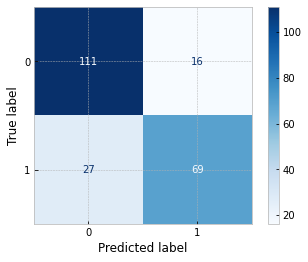

In [114]:
# plot confusion matrix
metrics.plot_confusion_matrix(lr, X_test, y_test,
                              values_format=".4g", 
                              cmap='Blues'
                             );

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


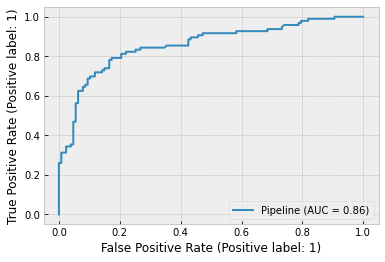

In [115]:
metrics.plot_roc_curve(lr, X_test, y_test)

In [116]:
def print_evaluation_metrics(model,X_train,X_test,y_train,y_test,y_pred):
    """ Print out some evaluation metrics """
    print(f'train score: {round(model.score(X_train,y_train),2)}')
    print(f'test score: {round(model.score(X_test,y_test),2)}')
    print(f'precision: {round(metrics.precision_score(y_test, y_pred, average="binary",pos_label=1),2)}') 
    print(f'recall: {round(metrics.recall_score(y_test, y_pred, average="binary",pos_label=1),2)}')
    print(f'f1: {round(metrics.f1_score(y_test, y_pred, average="binary",pos_label=1),2)}')

In [ ]:
print_evaluation_metrics(lr,X_train,X_test,y_train,y_test,y_pred)

train score: 0.83
test score: 0.81
precision: 0.81
recall: 0.72
f1: 0.76


In [167]:
# save evaluation metrics
def save_evaluation_metrics(classifier,classifier_name, summary ,X_train,y_train,X_test,y_test,y_pred):
    
    summary['Classifier Name'].append(classifier_name)
    summary['Train Score'].append(round(classifier.score(X_train, y_train),2))
    summary['Test Score'].append(round(classifier.score(X_test, y_test),2))
    summary['AUC'].append(round(metrics.roc_auc_score(y_test,classifier.predict_proba(X_test)[:, 1]),2))
    summary['Precision'].append(round(metrics.precision_score(y_test, y_pred, average="binary",pos_label=1),2)) 
    summary['Recall'].append(round(metrics.recall_score(y_test, y_pred, average="binary",pos_label=1),2))
    summary['F1'].append(round(metrics.f1_score(y_test, y_pred, average="binary",pos_label=1),2))
    
    return summary

In [120]:
summary = {'Classifier Name':[],'Train Score':[],'Test Score':[],
                   'AUC':[],'Precision':[],'Recall':[],'F1':[]}

summary = save_evaluation_metrics(lr,'Logistic Regressin',summary, X_train,y_train,X_test,y_test,y_pred)
summary

{'Classifier Name': ['Logistic Regressin'],
 'Train Score': [0.83],
 'Test Score': [0.81],
 'AUC': [0.86],
 'Precision': [0.81],
 'Recall': [0.72],
 'F1': [0.76]}

In [161]:
# cross validation
cross_val_score(lr, X_train, y_train, cv = 5, scoring='accuracy')

array([0.80597015, 0.84328358, 0.82089552, 0.81954887, 0.76691729])

In [162]:
cross_val_score(lr, X_train, y_train, cv = 5, scoring='accuracy').mean()

0.8113230838289753

### Decision Tree

#### Feature Engineering

Pipelines to be redesigned - no scalling and onehote encoding needed

##### Define Pipelines

In [121]:
# Name
name_pipe_dt = make_pipeline(
    FunctionTransformer(name_length),
)

In [122]:
# Sex
sex_pipe_dt = make_pipeline(
    OrdinalEncoder()
)

In [123]:
# Fare
fare_pipe_dt = make_pipeline(
    SimpleImputer(strategy='mean')
)

In [124]:
# Age
age_pipe_dt = make_pipeline(
    SimpleImputer(strategy='mean'),
)

In [125]:
# Cabin
cab_pipe_dt = make_pipeline(
     FunctionTransformer(get_deck),
     OrdinalEncoder()
)

In [126]:
# Embarked
emb_pipe_dt = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder()
)

In [127]:
feature_transform_dt = ColumnTransformer([
    ('do_nothing', 'passthrough', ['Pclass', 'Relatives']),
    ('sex_categorization', sex_pipe_dt, ['Sex']),
    ('fare_imputation', fare_pipe_dt, ['Fare']),
    ('age_imputing', age_pipe_dt, ['Age']),
    ('get_deck', cab_pipe_dt, ['Cabin']),
    ('impute_and_ordinal_encoder', emb_pipe_dt, ['Embarked']),
    ('name_length', name_pipe_dt, ['Name'])
])

In [128]:
feature_names_dt = ([
                        'Pclas', 'Relatives',
                        'Sex',
                        'Fare',
                        'Age',
                        'Cabin',
                        'Embarked',
                        'Name',
])

#### Create Classifier

In [129]:
dt = Pipeline([
    ('preprocessing',feature_transform_dt),
    ('m_dt',DecisionTreeClassifier(max_depth=4))
])

In [130]:
dt.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('do_nothing', 'passthrough',
                                                  ['Pclass', 'Relatives']),
                                                 ('sex_categorization',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Sex']),
                                                 ('fare_imputation',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['Fare']),
                                                 ('age_imputing',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())])...
                                                                   OrdinalEncoder())]),
                                                  ['Cabin']),
                                                 ('impute_and_ordinal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Embarked']),
                                                 ('name_length',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function name_length at 0x7fb902504670>))]),
                                                  ['Name'])])),
                ('m_dt', DecisionTreeClassifier(max_depth=4))])

In [131]:
y_pred = dt.predict(X_test)

#### Evaluate Classifier

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


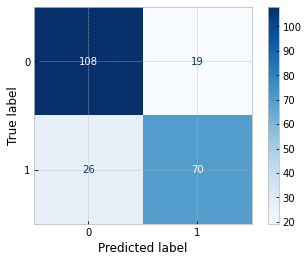

In [132]:
# plot confusion matrix
metrics.plot_confusion_matrix(dt, X_test, y_test,
                              values_format=".4g", 
                              cmap='Blues'
                             );

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


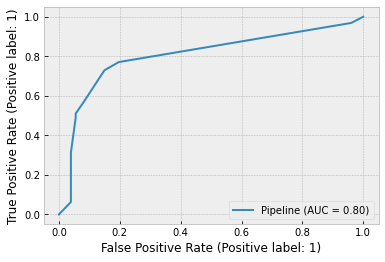

In [133]:
metrics.plot_roc_curve(dt, X_test, y_test)

In [135]:
summary = save_evaluation_metrics(dt,'Decision Tree',summary, X_train,y_train,X_test,y_test,y_pred)
summary

{'Classifier Name': ['Logistic Regressin', 'Decision Tree'],
 'Train Score': [0.83, 0.85],
 'Test Score': [0.81, 0.8],
 'AUC': [0.86, 0.8],
 'Precision': [0.81, 0.79],
 'Recall': [0.72, 0.73],
 'F1': [0.76, 0.76]}

In [169]:
# cross validation
cross_val_score(dt, X_train, y_train, cv = 5, scoring='accuracy').mean()

0.811367972169229

In [168]:
cross_val_score(dt, X_train, y_train, cv = 5, scoring='accuracy')

array([0.79850746, 0.81343284, 0.82835821, 0.83458647, 0.77443609])

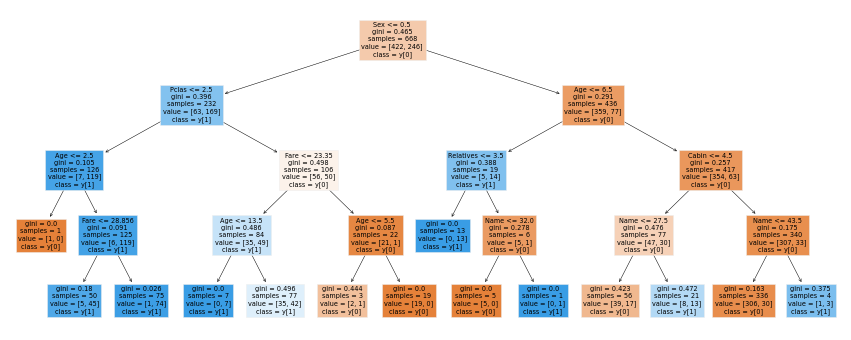

In [136]:
# Check tree and features used
plt.figure(figsize = (15,6))
plot_tree(dt['m_dt'], feature_names = feature_names_dt,class_names = True, filled = True);

In [137]:
# Feature importance
importance = pd.DataFrame(dt['m_dt'].feature_importances_)
importance.index = feature_names_dt

display(importance.sort_values(by = 0, ascending = False).head(10))

,0
Sex,0.540606
Pclas,0.150833
Age,0.102555
Cabin,0.062993
Fare,0.061773
Name,0.047819
Relatives,0.033422
Embarked,0.000000


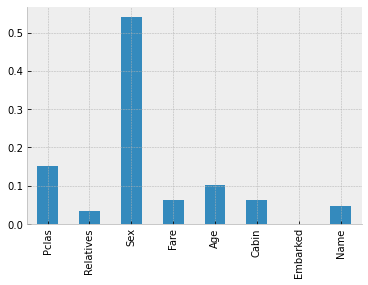

In [138]:
importance.plot.bar(legend=False)
sns.despine()

### Random Forest

#### Feature Engineering

##### Define Pielines

Decision tree's feature pipeline can be reused

#### Create Classifier

In [139]:
rf = Pipeline([
            ('preprocessor', feature_transform_dt),
            ('m_rf', RandomForestClassifier(n_estimators=100, max_depth=4))
])

In [140]:
rf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('do_nothing', 'passthrough',
                                                  ['Pclass', 'Relatives']),
                                                 ('sex_categorization',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Sex']),
                                                 ('fare_imputation',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['Fare']),
                                                 ('age_imputing',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),...
                                                                   OrdinalEncoder())]),
                                                  ['Cabin']),
                                                 ('impute_and_ordinal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Embarked']),
                                                 ('name_length',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function name_length at 0x7fb902504670>))]),
                                                  ['Name'])])),
                ('m_rf', RandomForestClassifier(max_depth=4))])

In [141]:
y_pred = rf.predict(X_test)

#### Evaluate Classifier

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


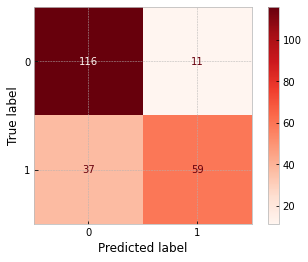

In [142]:
# plot confusion matrix
metrics.plot_confusion_matrix(rf, X_test, y_test,
                              values_format=".4g", 
                              cmap='Reds'
                             );

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


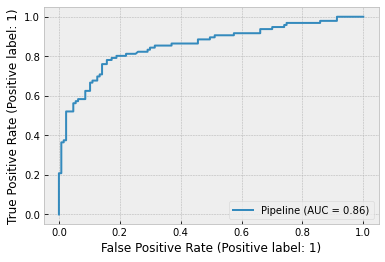

In [143]:
metrics.plot_roc_curve(rf, X_test, y_test)

In [145]:
summary = save_evaluation_metrics(rf,'Random Forest',summary, X_train,y_train,X_test,y_test,y_pred)
summary

{'Classifier Name': ['Logistic Regressin', 'Decision Tree', 'Random Forest'],
 'Train Score': [0.83, 0.85, 0.86],
 'Test Score': [0.81, 0.8, 0.78],
 'AUC': [0.86, 0.8, 0.86],
 'Precision': [0.81, 0.79, 0.84],
 'Recall': [0.72, 0.73, 0.61],
 'F1': [0.76, 0.76, 0.71]}

In [164]:
# cross validation
cross_val_score(rf, X_train, y_train, cv = 5, scoring='accuracy')

array([0.80597015, 0.7761194 , 0.82835821, 0.84962406, 0.77443609])

In [163]:
cross_val_score(rf, X_train, y_train, cv = 5, scoring='accuracy').mean()

0.818830658736393

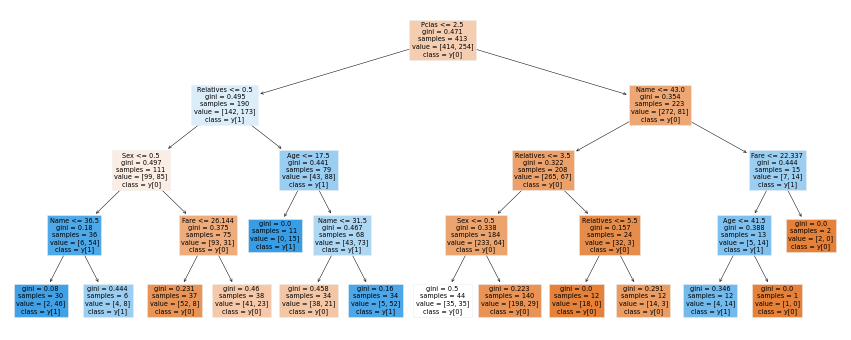

In [146]:
# Check tree and features used
plt.figure(figsize = (15,6))
plot_tree(rf['m_rf'][0], feature_names = feature_names_dt,class_names = True, filled = True);

In [147]:
# Feature importance
importance = pd.DataFrame(rf['m_rf'].feature_importances_)
importance.index = feature_names_dt

display(importance.sort_values(by = 0, ascending = False).head(10))

,0
Sex,0.351985
Name,0.139908
Fare,0.137656
Pclas,0.114555
Cabin,0.084893
Relatives,0.074907
Age,0.074072
Embarked,0.022023


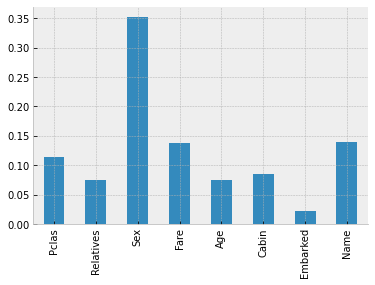

In [148]:
importance.plot.bar(legend=False)
sns.despine()

### Support Vector Machine

#### Feature Engineering

##### Define Pipelines

Logistic Regression's feature pipeline can be reused

#### Create Classifier

In [170]:
svm = Pipeline([
                ('preprocessor', feature_transform_lr),
                ('m_svm', SVC(kernel='rbf', C=10, probability=True))
])

In [154]:
svm.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('do_nothing', 'passthrough',
                                                  ['Pclass']),
                                                 ('name_length',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function name_length at 0x7fb902504670>))]),
                                                  ['Name']),
                                                 ('onehot_encoding',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Sex'])...
                                                                   FunctionTransformer(func=<function get_deck at 0x7fb8e1c1ddc0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Cabin']),
                                                 ('impute_and_onehot_encoding',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Embarked'])])),
                ('m_svm', SVC(C=10, probability=True))])

In [155]:
y_pred = svm.predict(X_test)

#### Evaluate Classifier

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


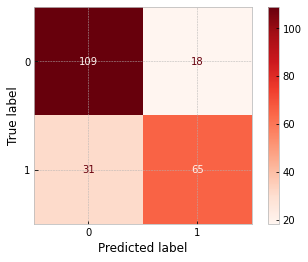

In [157]:
# plot confusion matrix
metrics.plot_confusion_matrix(svm, X_test, y_test,
                              values_format=".4g", 
                              cmap='Reds'
                             );

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


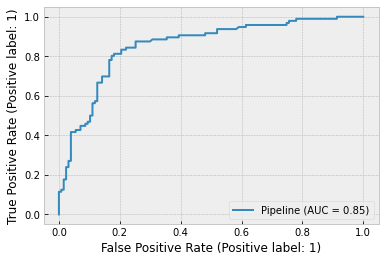

In [158]:
metrics.plot_roc_curve(svm, X_test, y_test)

In [160]:
summary = save_evaluation_metrics(svm,'Support Vector Machine',summary, X_train,y_train,X_test,y_test,y_pred)
summary

{'Classifier Name': ['Logistic Regressin',
  'Decision Tree',
  'Random Forest',
  'Support Vector Machine'],
 'Train Score': [0.83, 0.85, 0.86, 0.8],
 'Test Score': [0.81, 0.8, 0.78, 0.78],
 'AUC': [0.86, 0.8, 0.86, 0.85],
 'Precision': [0.81, 0.79, 0.84, 0.78],
 'Recall': [0.72, 0.73, 0.61, 0.68],
 'F1': [0.76, 0.76, 0.71, 0.73]}

In [165]:
# cross validation
cross_val_score(rf, X_train, y_train, cv = 5, scoring='accuracy')

array([0.79850746, 0.79850746, 0.84328358, 0.83458647, 0.80451128])

In [166]:
cross_val_score(rf, X_train, y_train, cv = 5, scoring='accuracy').mean()

0.817383009763214

### Voting Classifier

#### Create Classifier

In [172]:
vot = VotingClassifier(estimators=[
        ('lr',lr), 
        ('dt',dt), 
        ('rf', rf), 
        ('svm', svm)],       
        voting='soft'
)

In [174]:
vot.fit(X_train,y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preprocessing',
                                               ColumnTransformer(transformers=[('do_nothing',
                                                                                'passthrough',
                                                                                ['Pclass']),
                                                                               ('name_length',
                                                                                Pipeline(steps=[('functiontransformer',
                                                                                                 FunctionTransformer(func=<function name_length at 0x7fb902504670>))]),
                                                                                ['Name']),
                                                                               ('onehot_encoding',
                                                                                Pipeline(steps=[('onehotencoder',
                                                                                                 OneHotEncoder(handle_unknow...
                                                                                                 FunctionTransformer(func=<function get_deck at 0x7fb8e1c1ddc0>)),
                                                                                                ('onehotencoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse=False))]),
                                                                                ['Cabin']),
                                                                               ('impute_and_onehot_encoding',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('onehotencoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse=False))]),
                                                                                ['Embarked'])])),
                                              ('m_svm',
                                               SVC(C=10, probability=True))]))],
                 voting='soft')

In [175]:
y_pred = vot.predict(X_test)

#### Evaluate Classifier

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


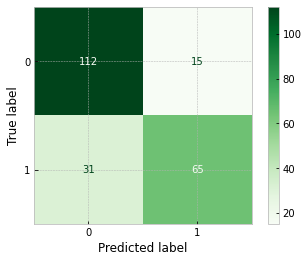

In [176]:
# plot confusion matrix
metrics.plot_confusion_matrix(vot, X_test, y_test,
                              values_format=".4g", 
                              cmap='Greens'
                             );

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


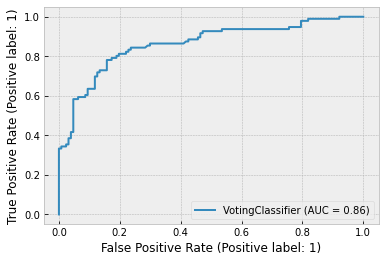

In [177]:
metrics.plot_roc_curve(vot, X_test, y_test)

In [178]:
summary = save_evaluation_metrics(vot,'Votting Classifier',summary, X_train,y_train,X_test,y_test,y_pred)
summary

{'Classifier Name': ['Logistic Regressin',
  'Decision Tree',
  'Random Forest',
  'Support Vector Machine',
  'Votting Classifier'],
 'Train Score': [0.83, 0.85, 0.86, 0.8, 0.85],
 'Test Score': [0.81, 0.8, 0.78, 0.78, 0.79],
 'AUC': [0.86, 0.8, 0.86, 0.85, 0.86],
 'Precision': [0.81, 0.79, 0.84, 0.78, 0.81],
 'Recall': [0.72, 0.73, 0.61, 0.68, 0.68],
 'F1': [0.76, 0.76, 0.71, 0.73, 0.74]}